In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc,roc_auc_score, confusion_matrix, roc_curve, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

import datetime as dt
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandasql import sqldf

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline

This is the final notebook for the  logistic regression analysis. Previous iterations are in the archive folder.

In [2]:
df = pd.read_csv('/Users/tawneykirkland/GitStuff/03-mcnulty/04-data/data.csv')
df.shape

(23524, 13)

In [3]:
x = df[['country', 'year', 'uniqueid', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type']]


y = df[['bank_account']]

x_tr, x_test, y_tr, y_test = train_test_split(x, y,test_size=.25, random_state=12)

In [4]:
x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
x_tr['is_male'] = np.where(x_tr['gender_of_respondent'] == 'Male',1,0)

<ipython-input-4-02e3f9e08314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
<ipython-input-4-02e3f9e08314>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
<ipython-input-4-02e3f9e08314>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [5]:
x_tr_cont = x_tr[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_tr_cat = x_tr[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [6]:
# Regroup to reduce number of categories
x_tr_cat.loc[x_tr['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_tr_cat.loc[x_tr['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_tr_cat.loc[x_tr['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_tr_cat.loc[x_tr['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-6-4a08e3cd5a34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr_cat.loc[x_tr['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-6-4a08e3cd5a34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [7]:
y_tr['no_acc'] = np.where(y_tr['bank_account'] == 'No', 1,0)
y_tr.drop(columns='bank_account',inplace=True)

<ipython-input-7-dc6323112d16>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_tr['no_acc'] = np.where(y_tr['bank_account'] == 'No', 1,0)
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_tr_cat)

ohe_x_train = ohe.transform(x_tr_cat)

columns = ohe.get_feature_names(['country',
                                 'relationship_with_head', 
                                 'marital_status',
                                 'education_level', 
                                 'job_type'])

ohe_x_tr_df = pd.DataFrame(ohe_x_train, columns=columns, index=x_tr.index)

In [9]:
combo_train_df = pd.concat([x_tr_cont, ohe_x_tr_df], axis=1)

In [10]:
x_train, x_val, y_train, y_val = train_test_split(combo_train_df, y_tr, test_size=.20, random_state=11)

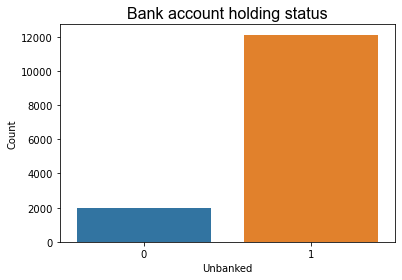

In [11]:
sns.countplot(x='no_acc', data=y_train)
plt.title('Bank account holding status',family='arial',fontsize=16)
plt.xlabel('Unbanked')
plt.ylabel('Count')
plt.show;

In [12]:
count_no_acc = len(y_train[y_train['no_acc']==1])
count_acc = len(y_train[y_train['no_acc']==0])
pct_of_no_acc = count_no_acc/(count_no_acc+count_acc)
print("percentage of no account:", round(pct_of_no_acc*100,2))
pct_of_acc = count_acc/(count_no_acc+count_acc)
print("percentage of account", round(pct_of_acc*100,2))

percentage of no account: 85.93
percentage of account 14.07


Classes are __very imbalanced__ - investigate threshold, over and undersampling

In [13]:
df_train = pd.concat([x_train,y_train],axis=1)
df_val = pd.concat([x_val,y_val],axis=1)

In [14]:
# Create dateframes to use for visualisations
df_vis_cont = pd.concat([x_tr_cont,y_tr],axis=1)
df_vis_cat = pd.concat([ohe_x_tr_df,y_tr],axis=1)

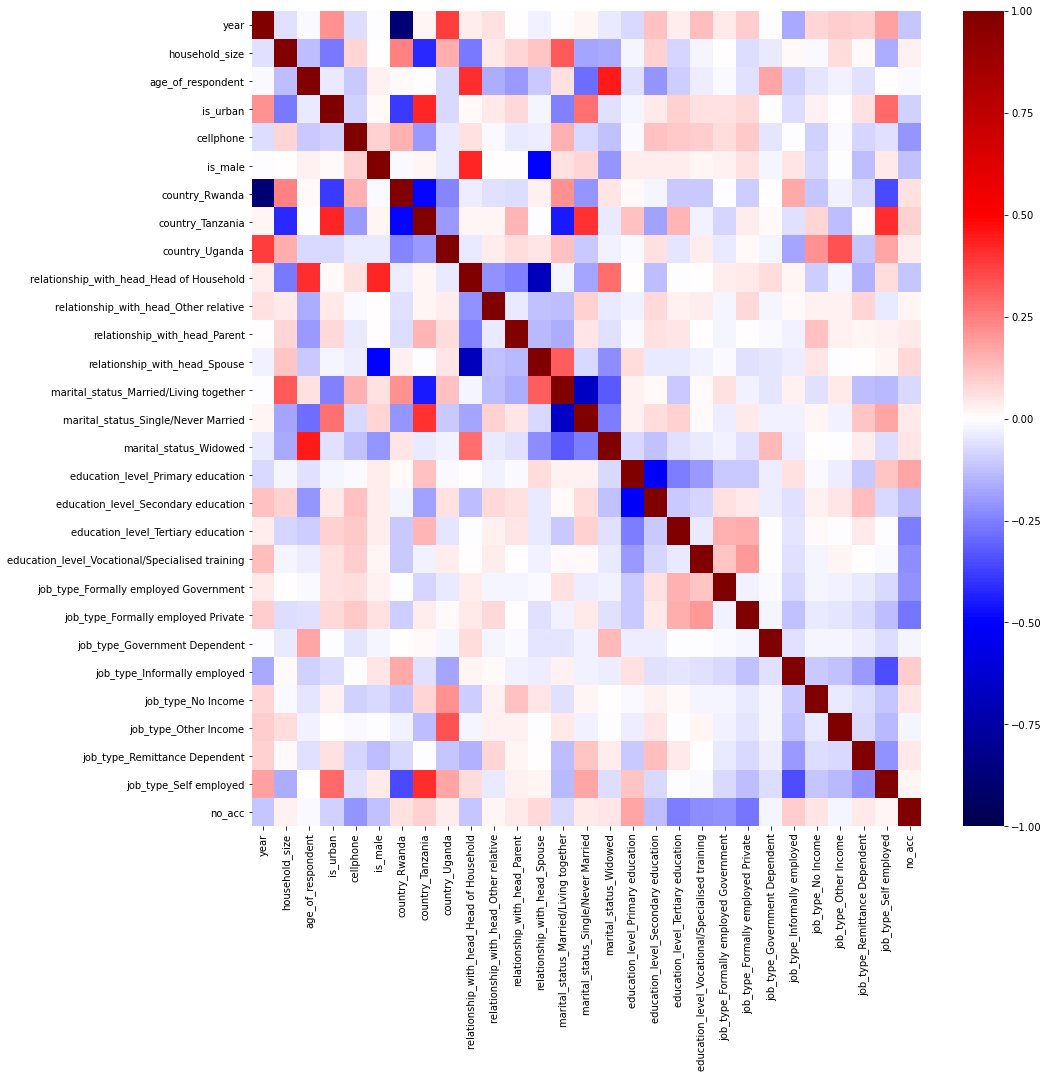

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_train.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

Note that some of these features are correlated and should be removed during analysis below

## Simple logistic regression

Testing with a single variable: is_male

In [16]:
#Model on is_male first
lm_1 = sm.Logit(df_train['no_acc'],  # with statsmodels, `y` comes first
                sm.add_constant(df_train[['is_male']]))  # and then `x`
lm_1 = lm_1.fit()

Optimization terminated successfully.
         Current function value: 0.399382
         Iterations 6


In [17]:
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 no_acc   No. Observations:                14114
Model:                          Logit   Df Residuals:                    14112
Method:                           MLE   Df Model:                            1
Date:                Sat, 15 May 2021   Pseudo R-squ.:                 0.01691
Time:                        07:57:37   Log-Likelihood:                -5636.9
converged:                       True   LL-Null:                       -5733.9
Covariance Type:            nonrobust   LLR p-value:                 4.398e-44
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1251      0.035     60.055      0.000       2.056       2.194
is_male       -0.6779      0.049    -13.887      0.000      -0.774      -0.582
==============================================================================
"""

In [18]:
lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm_1.fit(df_train[['is_male']], df_train['no_acc'])

LogisticRegression(C=100000, solver='newton-cg')

In [19]:
print('intercept: ', round(lm_1.intercept_[0], 3))
print('is_male coef: ', round(lm_1.coef_[0][0], 3))

intercept:  2.125
is_male coef:  -0.678


In [20]:
df_eval = df_val.copy()
df_eval['pred'] = lm_1.predict(df_val[['is_male']])
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['no_acc']

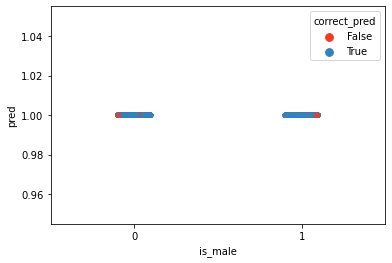

In [21]:
sns.stripplot(data=df_eval,
              x='is_male',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

In [22]:
lm_1.predict_proba(df_val[['is_male']])[:5]

array([[0.10668258, 0.89331742],
       [0.19044297, 0.80955703],
       [0.10668258, 0.89331742],
       [0.10668258, 0.89331742],
       [0.19044297, 0.80955703]])

In [23]:
confusion_matrix(df_eval['no_acc'], df_eval['pred'])

array([[   0,  492],
       [   0, 3037]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 3037 | 0|
| **is account (1)** | 492 | 0 |

I believe it is predicting all no account because of the following:
* Classes are very imbalanced (85:15 no account to account)
* One variable alone may not be sufficient enough in this instance
* Perhaps because is_male class is also imbalanced?

## Multiple regression
The below analysis is a multiple logistic regression for all features 

In [24]:
features = ['household_size', 'age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

The below analysis includes all features. Thereafter the analyses remove insignificant features one by one.

In [25]:
lm_2 = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
lm_2.fit(df_train[features], df_train['no_acc'])

preds = lm_2.predict(df_val[features])
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_2.score(df_val[features], y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [26]:
print('Feature coefficient results: \n')
for feature, coef in zip(df_train[features].columns, lm_2.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

household_size : -0.002
age_of_respondent : -0.013
is_urban : -0.272
cellphone : -1.633
is_male : -0.456
country_Rwanda : 0.336
country_Tanzania : 1.267
country_Uganda : 1.214
relationship_with_head_Head of Household : -0.798
relationship_with_head_Other relative : -0.122
relationship_with_head_Parent : -0.027
relationship_with_head_Spouse : -0.572
marital_status_Married/Living together : -0.037
marital_status_Single/Never Married : 0.125
marital_status_Widowed : -0.064
education_level_Primary education : -0.761
education_level_Secondary education : -1.763
education_level_Tertiary education : -3.234
education_level_Vocational/Specialised training : -2.773
job_type_Formally employed Government : -1.615
job_type_Formally employed Private : -1.725
job_type_Government Dependent : -1.214
job_type_Informally employed : 0.360
job_type_No Income : 0.187
job_type_Other Income : -0.673
job_type_Remittance Dependent : 0.203
job_type_Self employed : -0.463


In [27]:
lm_2.intercept_

array([5.66184332])

In [28]:
df_val['preds'] = lm_2.predict(df_val[features])

In [29]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [30]:
y_prob = lm_2.predict_proba(df_val[features])

In [31]:
confusion_matrix(df_val['no_acc'], 
                 preds)

array([[ 168,  324],
       [  79, 2958]])


| | predict banked (0) | predict unbanked (1)|
|---|---|---|
| **is banked (0)** | 168 | 324|
| **is UNbanked (1)** | 79 | 2958 |

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.68      0.34      0.45       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



The model should optimise for recall given the importance of identifying the unbanked and understanding the most important features linked to being unbanked. Therefore, the recall for the positive class is quite good. However, precision is comparatively low meaning that banked individuals are being classified as unbanked. 

Precision and recall for negative class are much lower - again because many banked are being classified as unbanked

In [33]:
df_val['proba_bank'] = lm_2.predict_proba(df_val[features])[:, 1]

fpr2, tpr2, thresholds2 = roc_curve(df_val['no_acc'],
                                 df_val['proba_bank'])

In [34]:
def plot_roc(true, probas,fpr,tpr):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

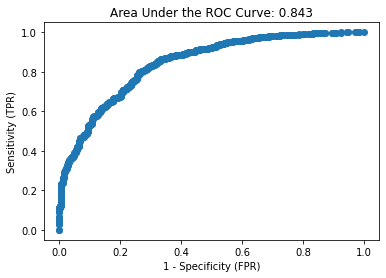

In [35]:
plot_roc(df_val['no_acc'], df_val['proba_bank'],fpr2,tpr2)

## Adjusting threshold

In [36]:
threshold = .55
y_pred = np.where((y_prob[:, 0] > threshold),0,1)

In [37]:
confusion_matrix(df_val['no_acc'], 
                 y_pred)

array([[ 149,  343],
       [  59, 2978]])

In [38]:
df_val['preds'] = np.where((y_prob[:, 0] > threshold),0,1)
df_comp = df_val[(df_val['no_acc'] != df_val['preds']) & (df_val['household_size'] ==1)]

In [39]:
print(classification_report(df_val['no_acc'], df_val['preds']))

              precision    recall  f1-score   support

           0       0.72      0.30      0.43       492
           1       0.90      0.98      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.81      0.64      0.68      3529
weighted avg       0.87      0.89      0.87      3529



As expected, improvement in prediction of the positive class but correct prediction of negative class (the banked population) declines

## Multiple regression removing unused features

#### Removing parent and other relative

In [40]:
x_train_9 = df_train.drop(columns = ['year','relationship_with_head_Parent','relationship_with_head_Other relative'])

df_val_9 = df_val.drop(columns = ['year','relationship_with_head_Parent','relationship_with_head_Other relative'])

features9 = ['age_of_respondent','household_size', 'is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

In [41]:
lm_9 = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
lm_9.fit(x_train_9[features9], x_train_9['no_acc'])

preds9 = lm_9.predict(df_val_9[features9])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(
    lm_9.score(df_val_9[features9], df_val_9['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.886


In [42]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_9[features9].columns, lm_9.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -0.013
household_size : -0.001
is_urban : -0.273
cellphone : -1.632
is_male : -0.456
country_Rwanda : 0.337
country_Tanzania : 1.264
country_Uganda : 1.209
relationship_with_head_Head of Household : -0.761
relationship_with_head_Spouse : -0.536
marital_status_Married/Living together : -0.035
marital_status_Single/Never Married : 0.132
marital_status_Widowed : -0.062
education_level_Primary education : -0.761
education_level_Secondary education : -1.762
education_level_Tertiary education : -3.232
education_level_Vocational/Specialised training : -2.773
job_type_Formally employed Government : -1.614
job_type_Formally employed Private : -1.730
job_type_Government Dependent : -1.213
job_type_Informally employed : 0.360
job_type_No Income : 0.188
job_type_Remittance Dependent : 0.204
job_type_Other Income : -0.672
job_type_Self employed : -0.462


In [43]:
confusion_matrix(df_val_9['no_acc'], 
                 preds9)

array([[ 169,  323],
       [  78, 2959]])

In [44]:
print(classification_report(df_val_9['no_acc'], preds9))

              precision    recall  f1-score   support

           0       0.68      0.34      0.46       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



Very minor improvement in prediction of both positive and negative classes

#### Removing married / living together

In [45]:
x_train_10 = x_train_9.drop(columns='marital_status_Married/Living together')

df_val_10 = df_val_9.drop(columns='marital_status_Married/Living together')

features10 = ['age_of_respondent','household_size', 'is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

In [46]:
lm_10 = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
lm_10.fit(x_train_10[features10], x_train_10['no_acc'])

preds10 = lm_10.predict(df_val_10[features10])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_10.score(
    df_val_10[features10], df_val_10['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.887


In [47]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_10[features10].columns, lm_10.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -0.013
household_size : -0.002
is_urban : -0.274
cellphone : -1.633
is_male : -0.460
country_Rwanda : 0.338
country_Tanzania : 1.273
country_Uganda : 1.209
relationship_with_head_Head of Household : -0.768
relationship_with_head_Spouse : -0.550
marital_status_Single/Never Married : 0.154
marital_status_Widowed : -0.036
education_level_Primary education : -0.762
education_level_Secondary education : -1.763
education_level_Tertiary education : -3.232
education_level_Vocational/Specialised training : -2.774
job_type_Formally employed Government : -1.614
job_type_Formally employed Private : -1.730
job_type_Government Dependent : -1.211
job_type_Informally employed : 0.361
job_type_No Income : 0.190
job_type_Remittance Dependent : 0.204
job_type_Other Income : -0.671
job_type_Self employed : -0.462


In [48]:
confusion_matrix(df_val_10['no_acc'], 
                 preds10)

array([[ 170,  322],
       [  78, 2959]])

In [49]:
print(classification_report(df_val_10['no_acc'], preds10))

              precision    recall  f1-score   support

           0       0.69      0.35      0.46       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



No change in prediction

In [50]:
df_val_10['proba_bank'] = lm_10.predict_proba(df_val_10[features10])[:, 1]

fpr10, tpr10, thresholds10 = roc_curve(df_val_10['no_acc'],
                                 df_val_10['proba_bank'])

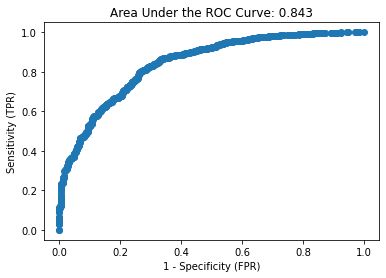

In [51]:
plot_roc(df_val_10['no_acc'], df_val_10['proba_bank'],fpr10,tpr10)

#### Removing household size

In [52]:
x_train_13 = x_train_10.drop(columns=['household_size'])

df_val_13 = df_val_10.drop(columns=['household_size'])

features13 = ['age_of_respondent','is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

In [53]:
lm_13 = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
lm_13.fit(x_train_13[features13], x_train_13['no_acc'])

preds13 = lm_13.predict(df_val_13[features13])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_13.score(
    df_val_13[features13], df_val_13['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.886


In [54]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_13.columns, lm_13.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -0.013
is_urban : -0.273
cellphone : -1.636
is_male : -0.462
country_Rwanda : 0.336
country_Tanzania : 1.274
country_Uganda : 1.207
relationship_with_head_Head of Household : -0.765
relationship_with_head_Spouse : -0.550
marital_status_Single/Never Married : 0.156
marital_status_Widowed : -0.035
education_level_Primary education : -0.763
education_level_Secondary education : -1.764
education_level_Tertiary education : -3.233
education_level_Vocational/Specialised training : -2.775
job_type_Formally employed Government : -1.614
job_type_Formally employed Private : -1.730
job_type_Government Dependent : -1.212
job_type_Informally employed : 0.361
job_type_No Income : 0.190
job_type_Other Income : 0.203
job_type_Remittance Dependent : -0.672
job_type_Self employed : -0.462


In [55]:
print('Intercept:', lm_13.intercept_)

Intercept: [5.60467835]


In [56]:
confusion_matrix(df_val_13['no_acc'], 
                 preds13)

array([[ 169,  323],
       [  78, 2959]])

In [57]:
print(classification_report(df_val_13['no_acc'], preds13))

              precision    recall  f1-score   support

           0       0.68      0.34      0.46       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



In [58]:
df_val_13['proba_bank'] = lm_13.predict_proba(df_val_13[features13])[:, 1]

fpr13, tpr13, thresholds13 = roc_curve(df_val_13['no_acc'],
                                 df_val_13['proba_bank'])

In [59]:
df_val_13['preds'] = lm_13.predict(df_val_13[features13])
df_check = df_val_13[(df_val_13['no_acc'] != df_val_13['preds']) & (df_val_13['proba_bank'] >= 0.65)]

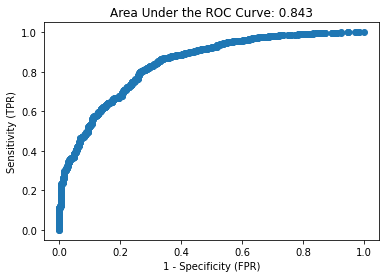

In [60]:
plot_roc(df_val_13['no_acc'], df_val_13['proba_bank'],fpr13,tpr13)
#plt.savefig("roc13.svg")

In [61]:
rw_wrong = len(df_check[df_check['country_Rwanda']==1]) / len(df_check)
tz_wrong = len(df_check[df_check['country_Tanzania']==1]) / len(df_check)
ug_wrong = len(df_check[df_check['country_Uganda']==1]) / len(df_check)
ke_wrong = 1 - rw_wrong - tz_wrong - ug_wrong
print("Rwanda wrong: {:0.3f} \nTanzania wrong: {:0.3f} \nUganda wrong: {:0.3f} \nKenya wrong: {:0.3f}".format(rw_wrong,tz_wrong,ug_wrong,ke_wrong))

Rwanda wrong: 0.372 
Tanzania wrong: 0.242 
Uganda wrong: 0.048 
Kenya wrong: 0.338


The majority of the highly confident, incorrect predictions are in Rwanda (37%) and Kenya (33%). Review Tableau dashboard to identify common features linked to highly confident, false predictions.

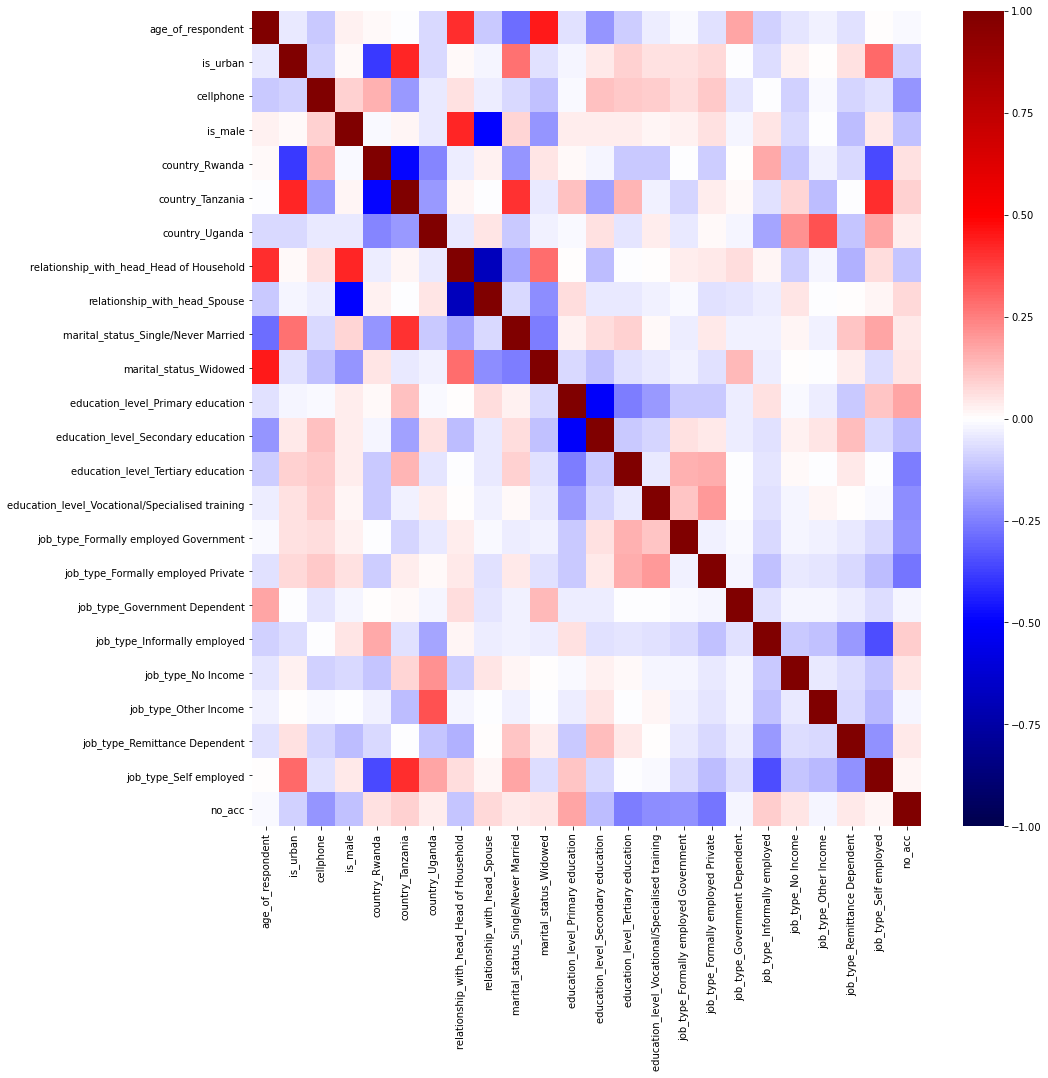

In [62]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(x_train_13.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

#### Oversampling with model 13 features

In [63]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(x_train_13[features13], x_train_13['no_acc'])

In [64]:
from collections import Counter
Counter(y_resampled)

Counter({1: 12128, 0: 12128})

In [65]:
lm_15 = LogisticRegression(C=1,penalty='l1',solver='liblinear')
lm_15.fit(X_resampled[features13], y_resampled)

preds15 = lm_15.predict(df_val_13[features13])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_15.score(
    df_val_13[features13], df_val_13['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.791


In [66]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_resampled.columns, lm_15.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -0.013
is_urban : -0.226
cellphone : -1.697
is_male : -0.495
country_Rwanda : 0.423
country_Tanzania : 1.405
country_Uganda : 1.406
relationship_with_head_Head of Household : -0.661
relationship_with_head_Spouse : -0.434
marital_status_Single/Never Married : 0.184
marital_status_Widowed : -0.106
education_level_Primary education : -0.801
education_level_Secondary education : -1.795
education_level_Tertiary education : -3.255
education_level_Vocational/Specialised training : -2.885
job_type_Formally employed Government : -1.727
job_type_Formally employed Private : -1.778
job_type_Government Dependent : -1.439
job_type_Informally employed : 0.334
job_type_No Income : 0.138
job_type_Remittance Dependent : 0.185
job_type_Other Income : -0.682
job_type_Self employed : -0.547


In [67]:
confusion_matrix(df_val_13['no_acc'], 
                 preds15)

array([[ 354,  138],
       [ 601, 2436]])

In [68]:
print(classification_report(df_val_13['no_acc'], preds15))

              precision    recall  f1-score   support

           0       0.37      0.72      0.49       492
           1       0.95      0.80      0.87      3037

    accuracy                           0.79      3529
   macro avg       0.66      0.76      0.68      3529
weighted avg       0.87      0.79      0.82      3529



As expected, improved prediction of the minority class but worse prediction of the majority (positive) class. 

#### Removing widowed

In [69]:
x_train_14 = x_train_13.drop(columns=['marital_status_Widowed'])

df_val_14 = df_val_13.drop(columns=['marital_status_Widowed'])

features14 = ['age_of_respondent','is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'marital_status_Single/Never Married',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

In [70]:
lm_14 = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
lm_14.fit(x_train_14[features14], x_train_14['no_acc'])

preds14 = lm_14.predict(df_val_14[features14])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_14.score(
    df_val_14[features14], df_val_14['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.886


In [71]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_14.columns, lm_14.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -0.013
is_urban : -0.273
cellphone : -1.632
is_male : -0.453
country_Rwanda : 0.335
country_Tanzania : 1.273
country_Uganda : 1.207
relationship_with_head_Head of Household : -0.765
relationship_with_head_Spouse : -0.539
marital_status_Single/Never Married : 0.160
education_level_Primary education : -0.760
education_level_Secondary education : -1.760
education_level_Tertiary education : -3.229
education_level_Vocational/Specialised training : -2.771
job_type_Formally employed Government : -1.612
job_type_Formally employed Private : -1.728
job_type_Government Dependent : -1.215
job_type_Informally employed : 0.362
job_type_No Income : 0.190
job_type_Other Income : 0.203
job_type_Remittance Dependent : -0.670
job_type_Self employed : -0.461


In [72]:
print('Intercept:', lm_14.intercept_)

Intercept: [5.59284262]


In [73]:
confusion_matrix(df_val_14['no_acc'], 
                 preds14)

array([[ 169,  323],
       [  78, 2959]])

In [74]:
print(classification_report(df_val_14['no_acc'], preds14))

              precision    recall  f1-score   support

           0       0.68      0.34      0.46       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



In [75]:
df_val_14['proba_bank'] = lm_14.predict_proba(df_val_14[features14])[:, 1]

fpr14, tpr14, thresholds14 = roc_curve(df_val_14['no_acc'],
                                 df_val_14['proba_bank'])

In [76]:
df_val_14['preds'] = lm_14.predict(df_val_14[features14])
df_check = df_val_14[(df_val_14['no_acc'] != df_val_14['preds']) & (df_val_14['proba_bank'] >= 0.65)]

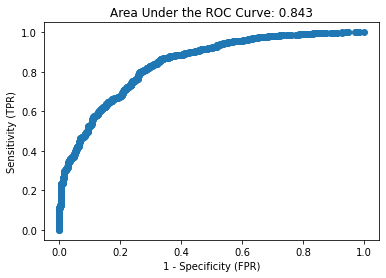

In [77]:
plot_roc(df_val_14['no_acc'], df_val_14['proba_bank'],fpr14,tpr14)
#plt.savefig("roc14.svg")

#### Removing Tanzania

In [80]:
x_train_16 = x_train_14.drop(columns=['country_Rwanda'])

df_val_16 = df_val_14.drop(columns=['country_Rwanda'])

features16 = ['age_of_respondent','is_urban', 'cellphone',
       'is_male', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

In [81]:
lm_16 = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
lm_16.fit(x_train_16[features16], x_train_16['no_acc'])

preds16 = lm_16.predict(df_val_16[features16])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_16.score(
    df_val_16[features16], df_val_16['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.887


In [82]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_16.columns, lm_16.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -0.015
is_urban : -0.314
cellphone : -1.612
is_male : -0.440
country_Tanzania : 1.210
country_Uganda : 1.050
relationship_with_head_Head of Household : -0.857
relationship_with_head_Spouse : -0.624
marital_status_Single/Never Married : -0.783
education_level_Primary education : -1.822
education_level_Secondary education : -3.289
education_level_Tertiary education : -2.873
education_level_Vocational/Specialised training : -1.653
job_type_Formally employed Government : -1.787
job_type_Formally employed Private : -1.201
job_type_Government Dependent : 0.337
job_type_Informally employed : 0.166
job_type_No Income : 0.149
job_type_Other Income : -0.650
job_type_Remittance Dependent : -0.515


In [83]:
print('Intercept:', lm_16.intercept_)

Intercept: [5.99681894]


In [84]:
confusion_matrix(df_val_16['no_acc'], 
                 preds16)

array([[ 172,  320],
       [  79, 2958]])

In [85]:
print(classification_report(df_val_16['no_acc'], preds16))

              precision    recall  f1-score   support

           0       0.69      0.35      0.46       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



In [86]:
df_val_16['proba_bank'] = lm_16.predict_proba(df_val_16[features16])[:, 1]

fpr16, tpr16, thresholds16 = roc_curve(df_val_16['no_acc'],
                                 df_val_16['proba_bank'])

In [87]:
df_val_16['preds'] = lm_16.predict(df_val_16[features16])
df_check = df_val_16[(df_val_16['no_acc'] != df_val_16['preds']) & (df_val_16['proba_bank'] >= 0.65)]

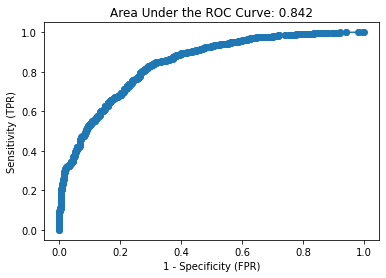

In [88]:
plot_roc(df_val_16['no_acc'], df_val_16['proba_bank'],fpr16,tpr16)
#plt.savefig("roc16.svg")

#### Removing Single

In [89]:
x_train_15 = x_train_14.drop(columns=['marital_status_Single/Never Married'])

df_val_15 = df_val_14.drop(columns=['marital_status_Single/Never Married'])

features15 = ['age_of_respondent','is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

In [90]:
lm_15 = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
lm_15.fit(x_train_15[features15], x_train_15['no_acc'])

preds15 = lm_15.predict(df_val_15[features15])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_15.score(
    df_val_15[features15], df_val_15['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.887


In [91]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_15.columns, lm_15.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -0.014
is_urban : -0.257
cellphone : -1.641
is_male : -0.449
country_Rwanda : 0.334
country_Tanzania : 1.336
country_Uganda : 1.200
relationship_with_head_Head of Household : -0.825
relationship_with_head_Spouse : -0.614
education_level_Primary education : -0.759
education_level_Secondary education : -1.757
education_level_Tertiary education : -3.227
education_level_Vocational/Specialised training : -2.768
job_type_Formally employed Government : -1.610
job_type_Formally employed Private : -1.721
job_type_Government Dependent : -1.190
job_type_Informally employed : 0.362
job_type_No Income : 0.180
job_type_Other Income : 0.218
job_type_Remittance Dependent : -0.660
job_type_Self employed : -0.457


In [92]:
print('Intercept:', lm_15.intercept_)

Intercept: [5.71212789]


In [93]:
confusion_matrix(df_val_15['no_acc'], 
                 preds15)

array([[ 170,  322],
       [  78, 2959]])

In [94]:
print(classification_report(df_val_15['no_acc'], preds15))

              precision    recall  f1-score   support

           0       0.69      0.35      0.46       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



In [95]:
df_val_15['proba_bank'] = lm_15.predict_proba(df_val_15[features15])[:, 1]

fpr15, tpr15, thresholds15 = roc_curve(df_val_15['no_acc'],
                                 df_val_15['proba_bank'])

In [96]:
df_val_15['preds'] = lm_15.predict(df_val_15[features15])
df_check = df_val_15[(df_val_15['no_acc'] != df_val_15['preds']) & (df_val_15['proba_bank'] >= 0.65)]

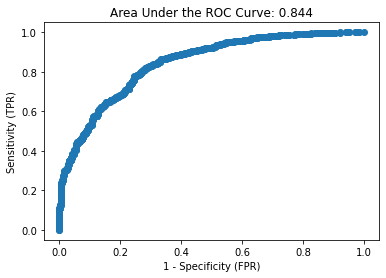

In [97]:
plot_roc(df_val_15['no_acc'], df_val_15['proba_bank'],fpr15,tpr15)
#plt.savefig("roc15.svg")

#### Removing Other income

In [98]:
x_train_16 = x_train_15.drop(columns=['job_type_Other Income'])

df_val_16 = df_val_15.drop(columns=['job_type_Other Income'])

features16 = ['age_of_respondent','is_urban', 'cellphone',
       'is_male', 'country_Tanzania','country_Rwanda', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Self employed']

In [99]:
lm_16 = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
lm_16.fit(x_train_16[features16], x_train_16['no_acc'])

preds16 = lm_16.predict(df_val_16[features16])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_16.score(
    df_val_16[features16], df_val_16['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.887


In [100]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_16.columns, lm_16.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -0.013
is_urban : -0.312
cellphone : -1.634
is_male : -0.444
country_Rwanda : 1.308
country_Tanzania : 0.329
country_Uganda : 1.023
relationship_with_head_Head of Household : -0.816
relationship_with_head_Spouse : -0.593
education_level_Primary education : -0.764
education_level_Secondary education : -1.773
education_level_Tertiary education : -3.253
education_level_Vocational/Specialised training : -2.788
job_type_Formally employed Government : -1.482
job_type_Formally employed Private : -1.566
job_type_Government Dependent : -1.081
job_type_Informally employed : 0.480
job_type_No Income : 0.387
job_type_Remittance Dependent : 0.351
job_type_Self employed : -0.299


In [101]:
print('Intercept:', lm_16.intercept_)

Intercept: [5.5994791]


In [102]:
confusion_matrix(df_val_16['no_acc'], 
                 preds16)

array([[ 170,  322],
       [  78, 2959]])

In [103]:
print(classification_report(df_val_16['no_acc'], preds16))

              precision    recall  f1-score   support

           0       0.69      0.35      0.46       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



In [104]:
df_val_16['proba_bank'] = lm_16.predict_proba(df_val_16[features16])[:, 1]

fpr16, tpr16, thresholds16 = roc_curve(df_val_16['no_acc'],
                                 df_val_16['proba_bank'])

In [105]:
df_val_16['preds'] = lm_16.predict(df_val_16[features16])
df_check = df_val_16[(df_val_16['no_acc'] != df_val_16['preds']) & (df_val_16['proba_bank'] >= 0.65)]

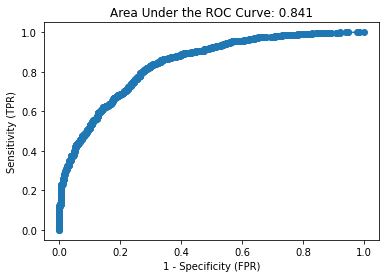

In [106]:
plot_roc(df_val_16['no_acc'], df_val_16['proba_bank'],fpr16,tpr16)
#plt.savefig("roc16.svg")

#### Removing Age of respondent

In [107]:
x_train_17 = x_train_16.drop(columns=['age_of_respondent'])

df_val_17 = df_val_16.drop(columns=['age_of_respondent'])

features17 = ['is_urban', 'cellphone',
       'is_male', 'country_Tanzania','country_Rwanda', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Self employed']

In [108]:
lm_17 = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
lm_17.fit(x_train_17[features17], x_train_17['no_acc'])

preds17 = lm_17.predict(df_val_17[features17])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_17.score(
    df_val_17[features17], df_val_17['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.882


In [109]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_17.columns, lm_17.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

is_urban : -0.301
cellphone : -1.587
is_male : -0.438
country_Rwanda : 1.322
country_Tanzania : 0.364
country_Uganda : 1.096
relationship_with_head_Head of Household : -1.034
relationship_with_head_Spouse : -0.727
education_level_Primary education : -0.655
education_level_Secondary education : -1.622
education_level_Tertiary education : -3.080
education_level_Vocational/Specialised training : -2.655
job_type_Formally employed Government : -1.426
job_type_Formally employed Private : -1.481
job_type_Government Dependent : -1.316
job_type_Informally employed : 0.568
job_type_No Income : 0.432
job_type_Remittance Dependent : 0.410
job_type_Self employed : -0.236


In [110]:
print('Intercept:', lm_17.intercept_)

Intercept: [5.01124339]


In [111]:
confusion_matrix(df_val_17['no_acc'], 
                 preds17)

array([[ 160,  332],
       [  84, 2953]])

In [112]:
print(classification_report(df_val_17['no_acc'], preds17))

              precision    recall  f1-score   support

           0       0.66      0.33      0.43       492
           1       0.90      0.97      0.93      3037

    accuracy                           0.88      3529
   macro avg       0.78      0.65      0.68      3529
weighted avg       0.87      0.88      0.86      3529



In [113]:
df_val_17['proba_bank'] = lm_17.predict_proba(df_val_17[features17])[:, 1]

fpr17, tpr17, thresholds17 = roc_curve(df_val_17['no_acc'],
                                 df_val_17['proba_bank'])

In [114]:
df_val_17['preds'] = lm_17.predict(df_val_17[features17])
df_check = df_val_17[(df_val_17['no_acc'] != df_val_17['preds']) & (df_val_17['proba_bank'] >= 0.65)]

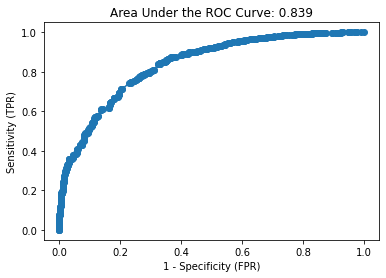

In [115]:
plot_roc(df_val_17['no_acc'], df_val_17['proba_bank'],fpr17,tpr17)
#plt.savefig("roc17.svg")

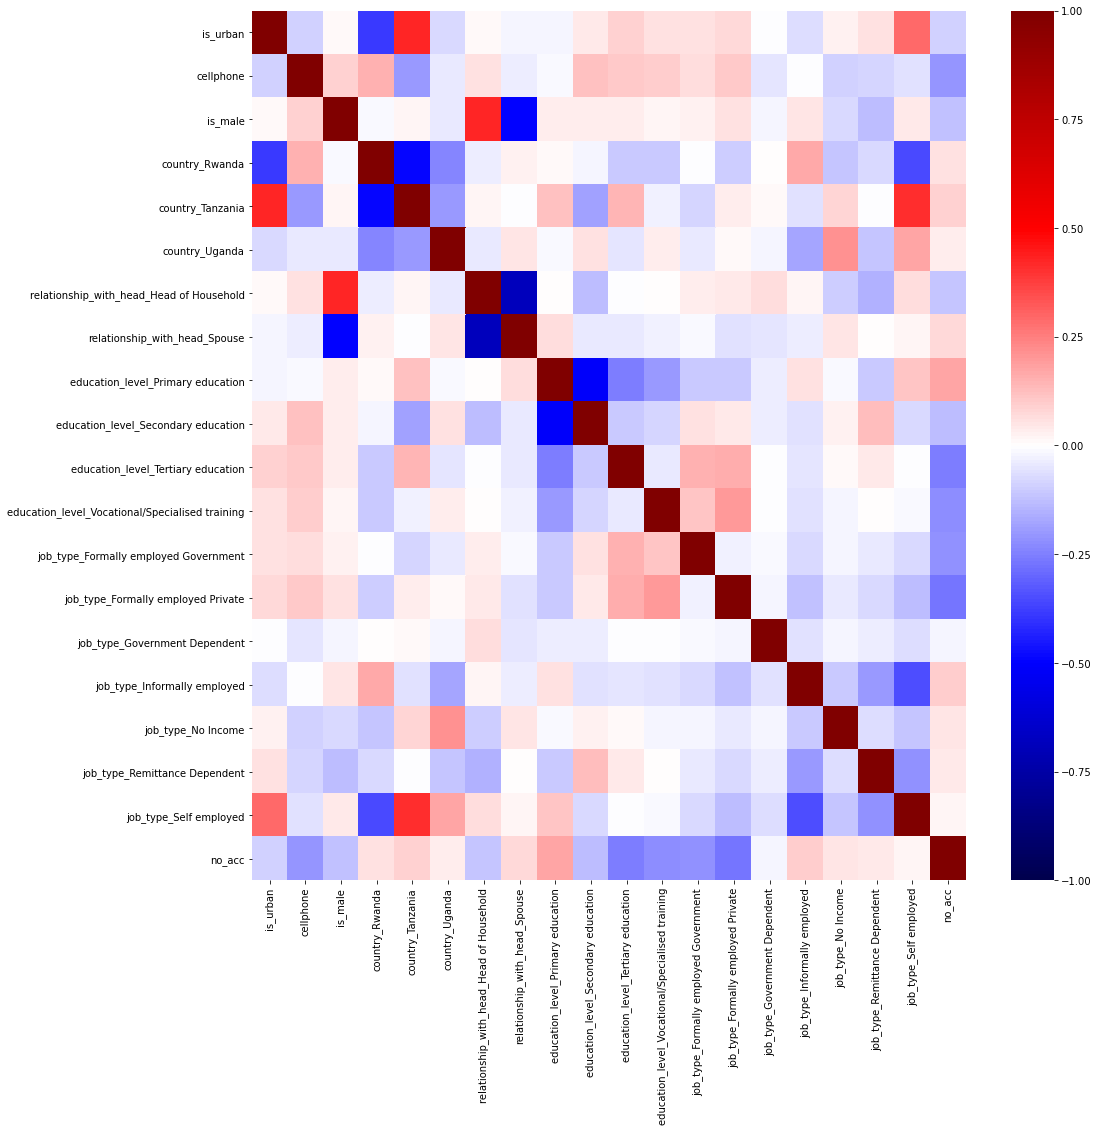

In [116]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(x_train_17.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

# Testing the model on the test set

Note the first analysis is based on the first multiple regression model above (including all features, no interactions)

## 1. Preparing the test sample 

In [117]:
x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
x_test['is_male'] = np.where(x_test['gender_of_respondent'] == 'Male',1,0)

<ipython-input-117-120e2e6065ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
<ipython-input-117-120e2e6065ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
<ipython-input-117-120e2e6065ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [118]:
x_test_cont = x_test[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_test_cat = x_test[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [119]:
x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_test_cat.loc[x_test_cat['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_test_cat.loc[x_test_cat['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_test_cat.loc[x_test_cat['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-119-c58a8d9a8085>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-119-c58a8d9a8085>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [120]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_test_cat)

ohe_x_test = ohe.transform(x_test_cat)

columns = ohe.get_feature_names(['country',
                                 'relationship_with_head', 
                                 'marital_status',
                                 'education_level', 
                                 'job_type'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=x_test.index)

In [121]:
combo_test_df = pd.concat([x_test_cont, ohe_x_test_df], axis=1)

In [122]:
y_test['no_acc'] = np.where(y_test['bank_account'] == 'No', 1,0)
y_test.drop(columns='bank_account',inplace=True)
df_test = pd.concat([combo_test_df,y_test],axis=1)

<ipython-input-122-41dba9f5dd1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['no_acc'] = np.where(y_test['bank_account'] == 'No', 1,0)
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## 2. Testing the model on the test sample

#### Model 1 - all features

In [123]:
preds1_test = lm_2.predict(df_test[features])
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(
    lm_2.score(df_test[features], df_test['no_acc'])))

Accuracy of logistic regression classifier on test set: 0.882


In [124]:
confusion_matrix(df_test['no_acc'], 
                 preds1_test)

array([[ 291,  543],
       [ 149, 4898]])


| | predict banked (0) | predict unbanked (1)|
|---|---|---|
| **is banked (0)** | 290 | 544|
| **is UNbanked (1)** | 149 | 4898 |

In [125]:
print(classification_report(df_test['no_acc'], preds1_test))

              precision    recall  f1-score   support

           0       0.66      0.35      0.46       834
           1       0.90      0.97      0.93      5047

    accuracy                           0.88      5881
   macro avg       0.78      0.66      0.70      5881
weighted avg       0.87      0.88      0.87      5881



Consistent performance across validation and test

#### Multiple regression with model 13

In [126]:
df_test_17 = df_test.copy()

In [127]:
preds17_test = lm_17.predict(df_test_17[features17])
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(
    lm_17.score(df_test_17[features17],df_test_17['no_acc'])))

Accuracy of logistic regression classifier on test set: 0.881


In [128]:
confusion_matrix(df_test_17['no_acc'], 
                 preds17_test)

array([[ 284,  550],
       [ 148, 4899]])

In [129]:
print(classification_report(df_test_17['no_acc'], preds17_test))

              precision    recall  f1-score   support

           0       0.66      0.34      0.45       834
           1       0.90      0.97      0.93      5047

    accuracy                           0.88      5881
   macro avg       0.78      0.66      0.69      5881
weighted avg       0.86      0.88      0.86      5881



Model is broadly consistent across train - val - test

In [130]:
df_test_17['proba_bank'] = lm_17.predict_proba(df_test_17[features17])[:, 1]

fpr17_test, tpr17_test, thresholds17_test = roc_curve(df_test_17['no_acc'],
                                 df_test_17['proba_bank'])

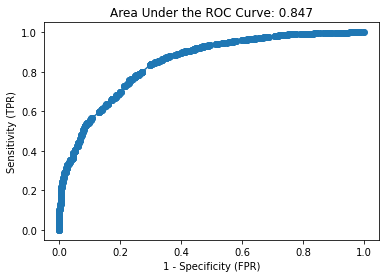

In [131]:
plot_roc(df_test_17['no_acc'], df_test_17['proba_bank'],fpr17_test,tpr17_test)

With model 13 the AUC is 0.853

In [132]:
df_test_17['preds'] = lm_17.predict(df_test_17[features17])

In [133]:
final_test = pd.concat([df_test_17,x_test_cat],axis=1)

In [134]:
# Send to csv for visualisation in Tableau
#final_test.to_csv('test_preds.csv')